In [9]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from omegaconf import OmegaConf
from bachelors_thesis.modeling.sigloc import SigLoc12
from bachelors_thesis.modeling.datasets.sigloc_dataset import SigLocDataset
from bachelors_thesis.modeling.train import eval_loop
import wandb

In [2]:
# Load the torch model from wandb
api = wandb.Api()
artifact = api.artifact("nateml-maastricht-university/bachelors-thesis/00_sigloc12_baseline_best:best")
artifact_path = artifact.download()

run = api.run("nateml-maastricht-university/bachelors-thesis/2ivqum26")
config = dict(run.config)

# Convert config to omegaconf
cfg = OmegaConf.create(config)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb:   1 of 1 files downloaded.  


In [3]:
cfg.model.feature_dim

64

In [17]:
# Load the model
checkpoint = torch.load(artifact_path + "/00_sigloc12_baseline_best.pth", map_location=torch.device('cuda'))

# Cast the model to the correct type
model = SigLoc12(cfg.model)
model.to("cuda")
model.load_state_dict(checkpoint)
model.eval()

SigLoc12(
  (local_encoder): LocalEncoder(
    (encoder): Sequential(
      (0): Conv1d(1, 16, kernel_size=(12,), stride=(1,), padding=(3,))
      (1): ReLU()
      (2): Conv1d(16, 32, kernel_size=(7,), stride=(1,), padding=(2,))
      (3): ReLU()
      (4): Conv1d(32, 64, kernel_size=(5,), stride=(1,), padding=(1,))
      (5): ReLU()
      (6): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
      (7): ReLU()
      (8): AdaptiveAvgPool1d(output_size=1)
      (9): Flatten(start_dim=1, end_dim=-1)
      (10): Linear(in_features=128, out_features=64, bias=True)
      (11): ReLU()
    )
  )
  (context_encoder): DeepSetsContextEncoder(
    (phi): Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): ReLU()
      (4): Linear(in_features=64, out_features=64, bias=True)
      (5): ReLU()
    )
    (rho): Sequential(
      (0): Linear(in_features=64, out_features=64, bias

In [66]:
# Load the validation data
val_data = np.load('../../data/processed/ptbxl100all/val.npy')

# Convert to tensor
val_data = torch.from_numpy(val_data).float()

# Reshape to (_, 6, 1000)
# val_data = val_data.view(-1, 6, 1000)
val_data = val_data.permute(0, 2, 1)
print(val_data.shape)

torch.Size([2183, 6, 1000])


In [67]:
# Create a dataloader for the validation data
dataset = SigLocDataset(val_data)
batch_size = 64
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

In [82]:
model.eval()
logits = np.zeros((len(dataset), 6, 6))
for idx, batch in enumerate(dataloader):
    # Move the batch to the GPU
    batch = batch.to('cuda')

    if idx == 0:
        print(batch.shape)
    
    # Make predictions
    with torch.no_grad():
        _, these_logits = model(batch)
        logits[(idx * batch_size):(idx * batch_size + batch_size)] = these_logits.cpu().numpy()

logits.shape

torch.Size([64, 6, 1000])


(2183, 6, 6)

In [83]:
targets = torch.arange(6, device=logits[0].device).expand(2183, -1)
targets.shape

torch.Size([2183, 6])

In [84]:
# Convert logits to tensor
logits = torch.from_numpy(logits).float()

In [89]:
# convert logits to probabilities
probs = torch.nn.functional.softmax(logits, dim=2)

# Display as numpy array, with percentages
probs = probs.cpu().numpy()
probs = np.round(probs * 100, 2)
# Display first item, without scientific notation
np.set_printoptions(suppress=True)
print(probs[0])


[[100.     0.     0.     0.     0.     0.  ]
 [  0.01  77.78  22.1    0.1    0.01   0.  ]
 [  0.     1.88  96.82   1.29   0.01   0.  ]
 [  0.     0.25   0.4   97.87   1.46   0.01]
 [  0.     0.1    0.01   1.36  98.16   0.37]
 [  0.02   0.07   0.01   0.01   0.22  99.67]]


In [ ]:
# Set level accuracy
all_preds = np.argmax(logits.cpu().numpy(), axis=2)
all_preds = all_preds.reshape(-1, 6)
mean_acc = np.mean(np.all(all_preds == targets.cpu().numpy(), axis=1).astype(float))
mean_acc

np.float64(0.755382501145213)

In [ ]:
# Lead-wise accuracy
preds = logits.argmax(dim=2)
correct = (preds == targets).float()
acc = correct.mean().item()
acc

0.9182317852973938

In [127]:
# Find outliers

# These are samples where the model predicted all 6 classes wrong 
outliers = np.where(np.all(all_preds != targets.cpu().numpy(), axis=1))[0]
print(all_preds[outliers][1])

print("Probabilities:")
print(probs[outliers][1])

# These are samples where the model predicted all 6 classes right
correct = np.where(np.all(all_preds == targets.cpu().numpy(), axis=1))[0]

[5 2 1 2 3 0]
Probabilities:
[[ 7.38  0.31  0.02  0.63  5.19 86.48]
 [ 1.64 19.41 36.63 34.57  6.73  1.02]
 [ 1.21 40.25 39.49 14.86  3.84  0.35]
 [ 0.65 38.76 44.09 14.45  1.86  0.19]
 [19.99  8.24 15.05 46.08  8.82  1.82]
 [58.66  0.29  0.03  2.26 11.58 27.18]]


In [134]:
# I want to find all cases where the model predicted a lead more than 2 "positions" away from the correct lead
# E.g. if the model predicted 0, but the correct lead was 3, this is a distance of 3
wrongness_thresh = 3
wrong = np.where(np.abs(all_preds - targets.cpu().numpy()) > wrongness_thresh)[0]
print(len(wrong))
print(all_preds[wrong])

71
[[0 2 3 3 0 5]
 [1 2 2 2 0 0]
 [1 2 2 2 0 0]
 [0 5 4 3 2 1]
 [0 5 4 3 2 1]
 [5 5 5 2 3 5]
 [5 5 5 2 3 5]
 [0 5 2 3 4 5]
 [5 0 1 2 2 4]
 [4 2 3 1 0 5]
 [4 2 3 1 0 5]
 [0 5 2 2 3 4]
 [0 5 1 2 4 4]
 [5 2 1 2 3 0]
 [5 2 1 2 3 0]
 [5 4 0 2 0 3]
 [5 4 0 2 0 3]
 [0 5 3 2 3 3]
 [0 5 2 3 5 1]
 [0 5 2 3 5 1]
 [5 4 0 1 3 4]
 [0 5 0 2 2 2]
 [4 5 0 2 3 4]
 [4 5 0 2 3 4]
 [3 2 2 3 0 0]
 [3 2 2 3 0 0]
 [0 5 4 4 2 5]
 [0 5 3 3 3 1]
 [0 5 3 3 3 1]
 [2 2 2 4 0 0]
 [2 2 2 4 0 0]
 [5 4 3 2 1 0]
 [5 4 3 2 1 0]
 [5 0 1 2 3 4]
 [5 0 1 2 3 4]
 [0 2 2 3 0 5]
 [5 3 2 3 0 0]
 [5 3 2 3 0 0]
 [5 3 2 3 0 0]
 [5 2 2 2 4 0]
 [5 2 2 2 4 0]
 [3 4 3 3 0 0]
 [3 4 3 3 0 0]
 [2 2 2 4 4 0]
 [4 4 5 2 0 4]
 [4 4 5 2 0 4]
 [5 4 2 2 3 5]
 [5 3 3 3 5 0]
 [5 3 3 3 5 0]
 [1 3 3 4 5 0]
 [4 2 2 3 4 5]
 [5 5 2 1 4 3]
 [5 5 2 1 4 3]
 [5 3 2 4 1 4]
 [0 5 2 2 4 5]
 [1 5 3 5 5 5]
 [0 5 1 2 2 3]
 [0 5 1 2 4 3]
 [5 1 1 2 2 5]
 [0 5 2 2 3 5]
 [0 5 2 1 3 4]
 [0 5 2 2 4 4]
 [5 0 1 2 3 4]
 [0 5 1 4 4 4]
 [4 2 2 5 0 5]
 [4 2 2 5 0 5]
 [4 5 2

In [ ]:
# Let's take a look at the metadata for these samples
metadata = np.load('../../data/processed/ptbxl100all/meta_val.npy', allow_pickle=True)
metadata = pd.DataFrame(metadata)
metadata.head()

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,11275.0,48.0,0,NaN,95.0,2.0,0.0,CS-12 E,1984-12-01 14:49:52,sinusrhythmus linkstyp qrs(t) abnormal infe...,...,", II,AVF",", I-AVF,",NaN,NaN,NaN,NaN,9,records100/00000/00008_lr,records500/00000/00008_hr,[MI]
1,9456.0,22.0,1,NaN,56.0,2.0,0.0,CS-12 E,1984-12-12 14:12:46,sinusrhythmus normales ekg,...,NaN,NaN,NaN,NaN,NaN,NaN,9,records100/00000/00010_lr,records500/00000/00010_hr,[NORM]
2,13619.0,56.0,0,NaN,NaN,2.0,0.0,CS-12 E,1985-01-20 14:25:25,vorhof:hf 280 tachykardes vorhofflimmern uebe...,...,NaN,", alles,",NaN,NaN,NaN,NaN,9,records100/00000/00017_lr,records500/00000/00017_hr,[]
3,13619.0,56.0,0,NaN,NaN,2.0,0.0,CS-12 E,1985-01-20 15:17:24,"vorhofflattern 2:1 Überleitung,jetzt nach isop...",...,NaN,", alles,",NaN,NaN,NaN,NaN,9,records100/00000/00018_lr,records500/00000/00018_hr,[]
4,13619.0,56.0,0,NaN,NaN,2.0,0.0,CS-12 E,1985-01-23 12:55:32,supraventrikulÄre ersatzsystole(n) interponier...,...,NaN,NaN,NaN,NaN,VES,NaN,9,records100/00000/00020_lr,records500/00000/00020_hr,[]


In [179]:
outliers[4]

np.int64(581)

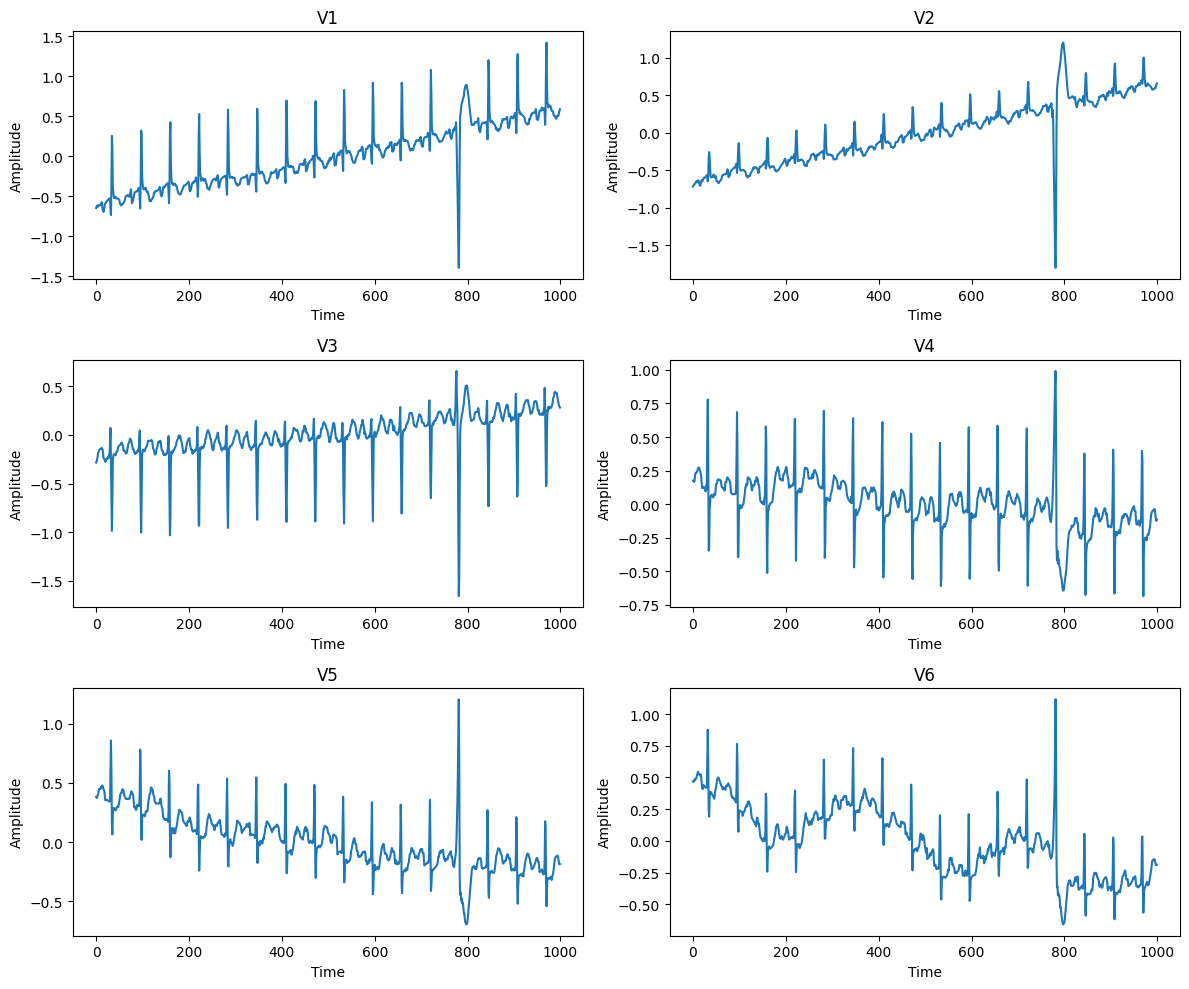

In [171]:
# lets take a look at the signals from the first outlier
import matplotlib.pyplot as plt

signals = val_data[outliers[4]].cpu().numpy()

def plot_signals(signals, time_cutoff=None):
    # Plot each precordial lead
    if time_cutoff is None:
        time_cutoff = signals.shape[1]

    plt.figure(figsize=(12, 10))
    for i in range(6):
        plt.subplot(3, 2, i + 1)
        plt.plot(signals[i][:time_cutoff])
        plt.title(f"V{i+1}")
        plt.xlabel("Time")
        plt.ylabel("Amplitude")
    plt.tight_layout()
    plt.show()

plot_signals(signals, time_cutoff=1000)

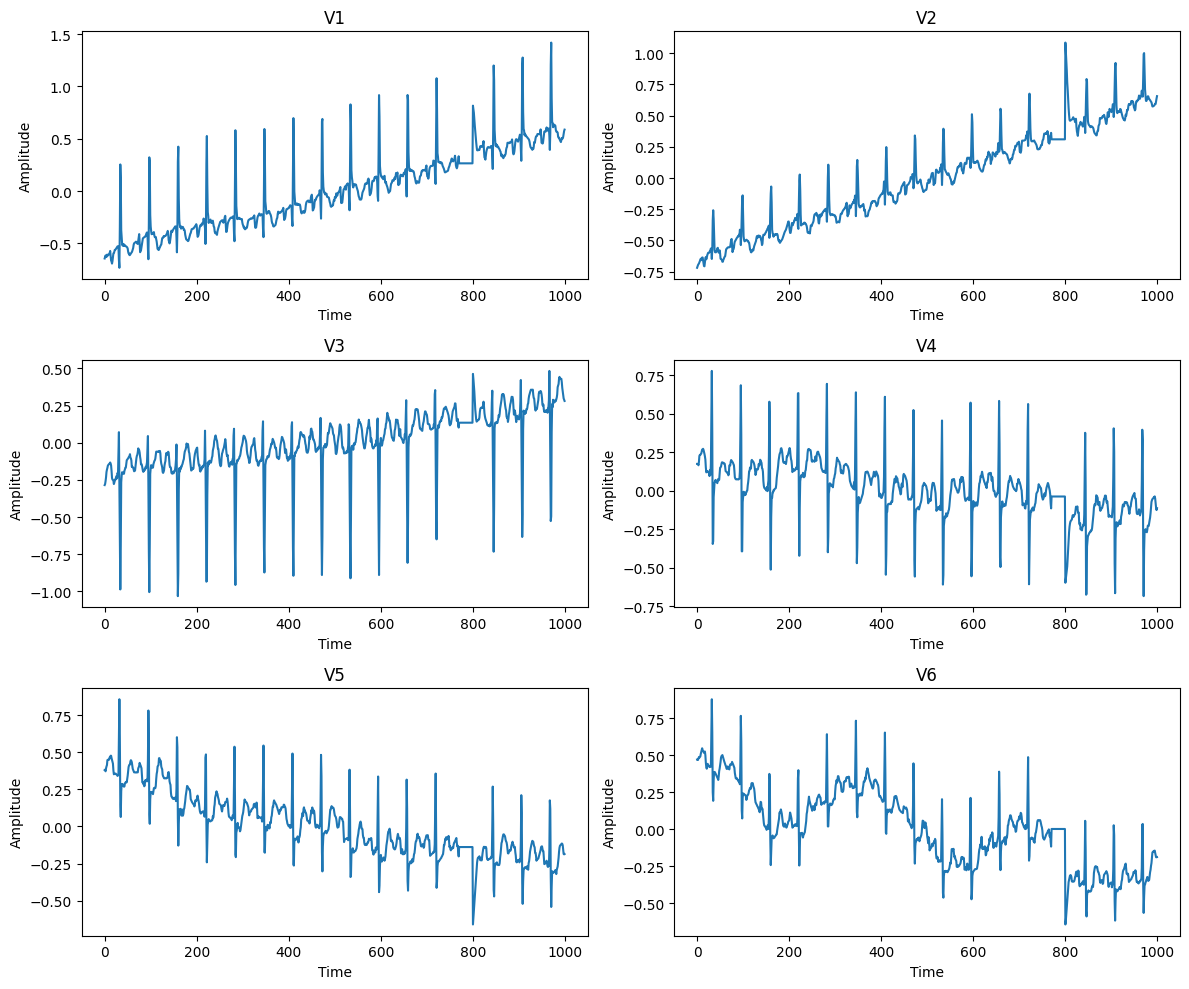

In [173]:
# Lets try remove the artifact at the end of the signal by zeroing it out
signals_corrected = signals.copy()
for i in range(signals_corrected.shape[0]):
    signals_corrected[i][770:800] = np.mean(signals_corrected[i][700:770])
plot_signals(signals_corrected, time_cutoff=1000)

In [178]:
# Lets try to predict again with the corrected signals
signals_corrected_torch = torch.from_numpy(signals_corrected.reshape(1, 6, 1000)).float().to('cuda')
print(signals_corrected_torch.shape)
with torch.no_grad():
    _, these_logits = model(signals_corrected_torch)

# Convert logits to probabilities
probs = torch.nn.functional.softmax(these_logits, dim=2)

# Display as numpy array, with percentages
probs = probs.cpu().numpy()
probs = np.round(probs * 100, 2)
# Display first item, without scientific notation
np.set_printoptions(suppress=True)
print(probs)

# Display the predicted lead
pred = np.argmax(these_logits.cpu().numpy(), axis=2)
print(pred)

torch.Size([1, 6, 1000])
[[[ 0.02  0.07  0.03  1.39 95.77  2.72]
  [ 0.53  0.41  0.19  0.27  0.52 98.08]
  [99.17  0.8   0.    0.    0.01  0.02]
  [ 0.22 61.44 37.97  0.09  0.14  0.15]
  [ 0.4   9.89 73.69 13.82  1.64  0.56]
  [ 0.98 10.52 20.18 56.35  8.77  3.2 ]]]
[[4 5 0 1 2 3]]


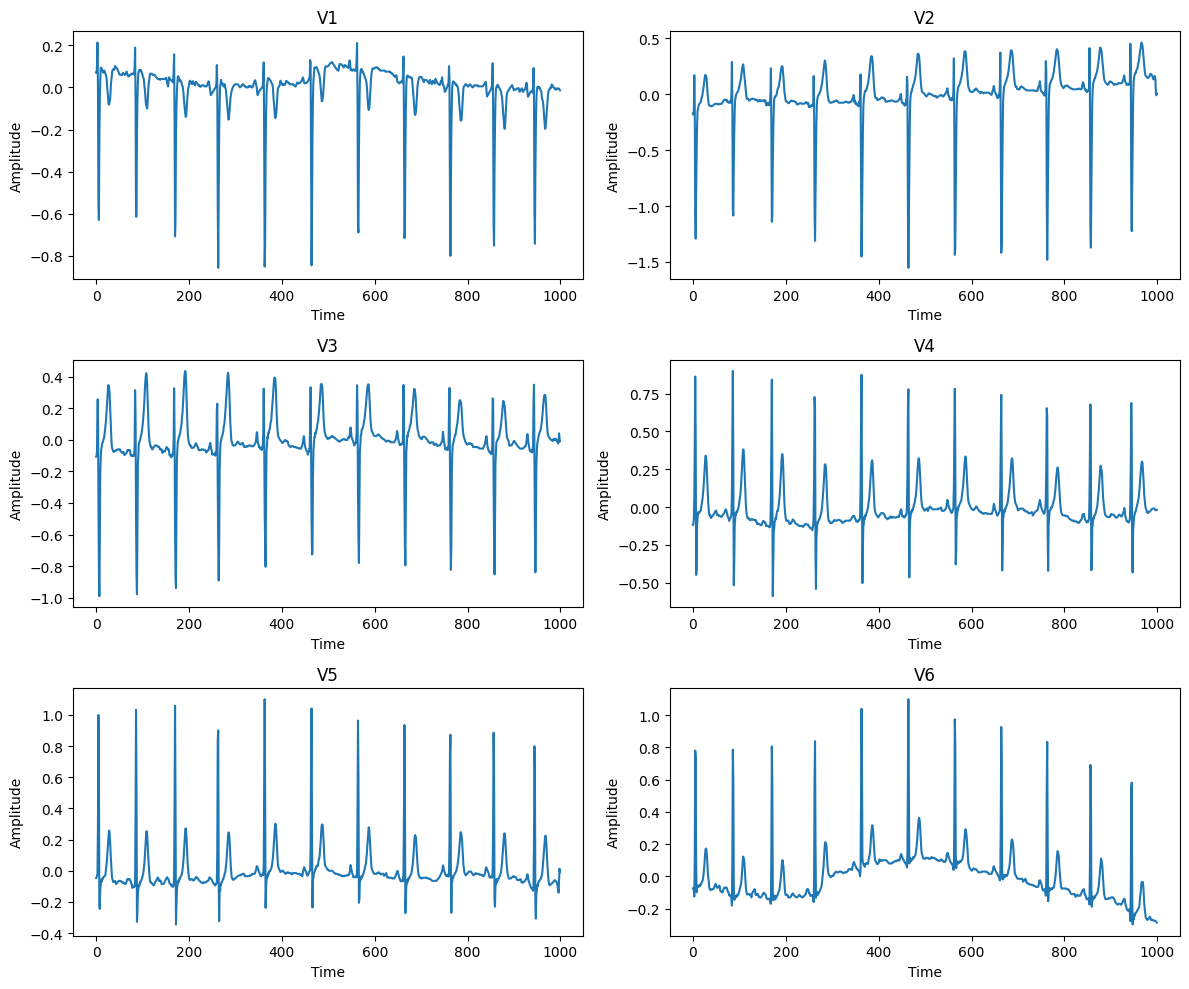

In [176]:
# lets do the same visualization for the first correct sample
signals = val_data[correct[1]].cpu().numpy()

plot_signals(signals, time_cutoff=1000)

The above uses a model that was not trained on preprocessed data. I will now evaluate a model that was trained on data with a highpass filter to remove baseline wander.